In [1]:
import sys,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from scipy import stats

In [2]:
scipy.__version__

'1.6.2'

In [3]:
color_SP1="#bc5b2d"
color_SP1_light="#c79076"
color_cMyc="#030c7b"
color_cMyc_light="#6870d1"

colors_lines={"control":"gray","cMyc":color_cMyc,"SP1":color_SP1,"SP1/cMyc":"k"}
colors_lines_alpha={"control":"gray","cMyc":color_cMyc_light,"SP1":color_SP1_light,"SP1/cMyc":"gray"}

Read the data.

In [4]:
folder="./data/dataset2_rawdata_FI_csv/"
columns=["DAPI","GFP","synTF"]
dfs=[] 
names=["Control","MYC","SP1","SP1MYC"] #names of .csv files
names_to_keys={"Control":"control","MYC":"cMyc","SP1":"SP1","SP1MYC":"SP1/cMyc"} 
for name in names:
    df=pd.read_csv(os.path.join(folder,name+".csv"),names=columns)
    df.name=names_to_keys[name]
    dfs.append(df)


control 27332 cells
cMyc 6862 cells
SP1 5909 cells
SP1/cMyc 6252 cells
control 27332 cells
cMyc 6862 cells
SP1 5909 cells
SP1/cMyc 6252 cells


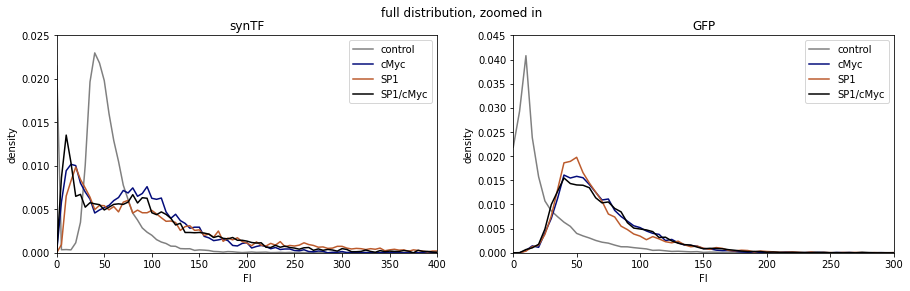

In [5]:
#distribution of input and output, zoom in and with bins separated by 5

column1="synTF"
column2="GFP"

columns=[column1,column2]
fig,axes=plt.subplots(1,2,figsize=(15,4))
fig.suptitle("full distribution, zoomed in")
for c,column in enumerate(columns):
    
    ax=axes[c]
    for d,df in enumerate(dfs):
        condition=df.name
        print(condition,len(df), "cells")
        data=df[column].values
        bins=np.arange(0,data.max()+5,5)
        
        hist,edges=np.histogram(df[column].values,density=True,bins=bins)
        ax.plot(edges[:-1],hist,label=condition,color=colors_lines[condition])
        
        ax.set_title(column)
        
    ax.legend()
ax=axes[0]
ax.set_xlim(0,400)
ax.set_ylim(0,0.025)
ax=axes[1]
ax.set_xlim(0,300)
ax.set_ylim(0,0.045)
for ax in axes:
    ax.set_xlabel("FI")
    ax.set_ylabel("density")
plt.show()

Remove outliers based on the GFP signal, which can correspond to badly segmented cells or sick cells:

In [6]:
dfs_noout=[] #list with datasets without outliers

for df in dfs:
    
    
    GFPvals=df["GFP"].values
    th_low_g=np.quantile(GFPvals,0.05)
    th_high_g=np.quantile(GFPvals,0.95)
    mask2=(GFPvals>th_low_g)&(GFPvals<th_high_g)
    
    df_s=df[mask2].copy()
    df_s.name=df.name
    
    dfs_noout.append(df_s)



Now look again at the data:

control 24594 cells after removing outliers
cMyc 6174 cells after removing outliers
SP1 5317 cells after removing outliers
SP1/cMyc 5626 cells after removing outliers
control 24594 cells after removing outliers
cMyc 6174 cells after removing outliers
SP1 5317 cells after removing outliers
SP1/cMyc 5626 cells after removing outliers


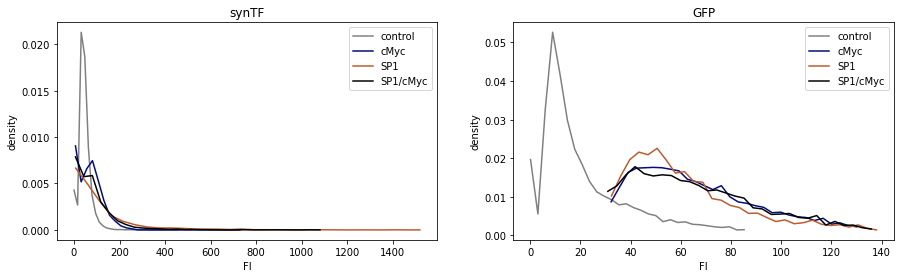

In [8]:
column1="synTF"
column2="GFP"

columns=[column1,column2]
fig,axes=plt.subplots(1,2,figsize=(15,4))
for c,column in enumerate(columns):
    ax=axes[c]
    for d,df in enumerate(dfs_noout):
        condition=df.name
        print(condition,len(df),"cells after removing outliers")
        
        hist,edges=np.histogram(df[column].values,density=True,bins=30)
        ax.plot(edges[:-1],hist,label=condition,color=colors_lines[condition])
        
        ax.set_title(column)
        ax.set_xlabel("FI")
        ax.set_ylabel("density")
    ax.legend()
plt.show()

Note that there is a long tail for SP1 and also a bit for SP1/cMYC but this affects a small population of cells:

In [9]:
for df in dfs_noout:
    n=np.sum(df["synTF"]>350)
    p=100*n/len(df)
    print(df.name,"cells with a fl>350: %d (%g %%)"%(n,p))

control cells with a fl>350: 2 (0.00813206 %)
cMyc cells with a fl>350: 2 (0.0323939 %)
SP1 cells with a fl>350: 351 (6.60147 %)
SP1/cMyc cells with a fl>350: 125 (2.22183 %)


Now define define cutoff to define positively transfected cells as the 90% percentile of the control

In [10]:

df=dfs_noout[0] #control data
q_synTF_ctrl=0.90

synTFvals=df["synTF"].values

cutoff_val_ctrl=np.quantile(synTFvals,q_synTF_ctrl)
print(cutoff_val_ctrl)


82.73611983582377


In [11]:
#Now for the positively transfected cells, pull together into a single df called alldata
allpositive=[]
for df in dfs_noout[1:]:
    subdf=df[df["synTF"]>cutoff_val_ctrl].copy()
    subdf["synTF fc"]=subdf["synTF"]/cutoff_val_ctrl
    subdf["name"]=df.name
    
    allpositive.append(subdf)
    
alldata=pd.concat(allpositive)
    
    

Now add fold-change with respect to mean GFP of the control (I also tried median GFP of the control, and 2x median, with essentially same results, as it only scales the data).

In [12]:


GFP_ctrl=dfs_noout[0]["GFP"]
mean_GFP_ctrl=GFP_ctrl.mean()
alldata["GFP fc (mean)"]=alldata["GFP"]/mean_GFP_ctrl
    

Now alldata only contains the positively transfected cells for those conditions that are not the control.

In [13]:
#now look at mean GFP and median GFP for cells that are positively transfected 

print("considering %g cutoff for positive transfection"%q_synTF_ctrl)
subdf=alldata
print(subdf.groupby("name")["GFP"].median().to_frame().T)
print(subdf.groupby("name")["GFP"].mean().to_frame().T)
print(subdf.groupby("name")["GFP fc (mean)"].mean().to_frame().T)
print("")

considering 0.9 cutoff for positive transfection
name        SP1   SP1/cMyc       cMyc
GFP   67.211383  78.576028  74.667994
name        SP1   SP1/cMyc       cMyc
GFP   72.836999  80.950235  77.508913
name                SP1  SP1/cMyc      cMyc
GFP fc (mean)  3.123499  3.471422  3.323846



Note that always the GFP for the combination is higher than the individual TFs.

In [14]:
alldata.groupby("name")["synTF"].max()

name
SP1         1570.894256
SP1/cMyc    1117.041612
cMyc         753.621851
Name: synTF, dtype: float64

Look at distribution of input and output fluorescences for positively transfected cells. Because there is variability in the input levels, do for all cells, as well as for cells with similar input levels i.e. input within the same range, so up to that observed in the Myc dataset. Test for non-significant difference. For this kind of data, both the Kolmogorov-Smirnov test and the Mann Whitney U test (Mann–Whitney–Wilcoxon (MWW/MWU), Wilcoxon rank-sum test, or Wilcoxon–Mann–Whitney test)

**Mann-Whitney U test**

From wikipedia:
- The Mann Whitney U test is a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X. 

From scipy manual mannwhitneyu(x, y):

- Under the null hypothesis H0, the distributions of both populations are identical.

- The alternative hypothesis H1 is that the distributions are not identical.

- For the one-sided test, with alternative "less", the alternative hypothesis is that the distribution underlying x is stochastically less than the distribution underlying y, i.e. F(u) > G(u) for all u.


**Kolmogorov-Smirnov test**

From Scipy manual ks_2samp(data1, data2)"

This test compares the underlying continuous distributions F(x) and G(x) of two independent samples. See Notes for a description of the available null and alternative hypotheses.

alternative=greater: The null hypothesis is that F(x) <= G(x) for all x; the alternative is that F(x) > G(x) for at least one x.

Note that the alternative hypotheses describe the CDFs of the underlying distributions, not the observed values. For example, suppose x1 ~ F and x2 ~ G. If F(x) > G(x) for all x, the values in x1 tend to be less than those in x2.

Therefore, the test will give a small p-value when the alternative is greater, when the values of data1 are less than the values of data2, in which case we can reject the null that CDF(data1)<=CDF(data2).


In [15]:
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

In [20]:
#check the implementation of the tests. Do for two normally distributed samples even if these tests are good for non-normal data
x=np.random.normal(1,5,size=100)
y=np.random.normal(3,5,size=100)
ks_2samp(x,y,alternative="greater"),mannwhitneyu(x,y,alternative="less")

(KstestResult(statistic=0.27, pvalue=0.0006467529891200971),
 MannwhitneyuResult(statistic=3600.0, pvalue=0.0003136554367851331))

In [25]:
def check_significance(df,sth=0.001,inputcol="synTF fc",outputcol="GFP fc (mean)",returnval=False,verbose=True):
    #input values
    i1=df[df["name"]=="SP1"][inputcol].values
    i2=df[df["name"]=="cMyc"][inputcol].values
    i12=df[df["name"]=="SP1/cMyc"][inputcol].values

    #test whether the input in the combination is higher than in the individuals. This should not be the case, otherwise it is expected that also the output is higher.
    
    for i in [1]: #originally I also looked at two-sided test but one-sided makes more sense
        if i==1: #one-sided test
            alternativeiks="greater"
            alternativeimw="less"
            comparisons=["combi greater than SP1?", "combi greater than Myc?" ]
        else: #this only tests for the null that that two datasets are equal
            alternativeiks="two-sided"
            alternativeimw="two-sided"
            comparisons=["combi different than SP1", "combi different than Myc"]

        #ksi_1_2=ks_2samp(i1,i2,alternative=alternativeiks)
        ksi_1_12=ks_2samp(i1,i12,alternative=alternativeiks)
        ksi_2_12=ks_2samp(i2,i12,alternative=alternativeiks)

        
        #mi_1_2=mannwhitneyu(i1,i2,alternative=alternativeimw)
        mi_1_12=mannwhitneyu(i1,i12,alternative=alternativeimw)
        mi_2_12=mannwhitneyu(i2,i12,alternative=alternativeimw)


        if verbose:
            
            print("- ks test for inputs", end=",")
            if i==1:
                print(" (one-sided)")
            else:
                print(" (two-sided)")

            for k_,ks in enumerate([ksi_1_12,ksi_2_12]):
                if ks[1]<sth:
                    sign="*"
                    text="significantly different"
                else:
                    sign="not s"
                    text="not significantly different"
                print(sign, comparisons[k_],text, "p=",ks[1])

            print("- mann whitney u test for inputs")

            for m_,mw in enumerate([mi_1_12,mi_2_12]):
                if mw[1]<sth:
                    sign="*"
                    text="significantly different"
                else:
                    sign="not s"
                    text="not significantly different"
                print(sign,comparisons[m_],text,"p=",mw[1])


    #outputs
    
    o1=df[df["name"]=="SP1"][outputcol].values
    o2=df[df["name"]=="cMyc"][outputcol].values
    o12=df[df["name"]=="SP1/cMyc"][outputcol].values
    
    for i in [1]:#originally I also looked at two-sided test but one-sided makes more sense
        if i==1:
            alternativeoks="greater"
            alternativeomw="less"
            comparisons=["combi greater than SP1?", "combi greater than Myc?" ]
        else:
            alternativeoks="two-sided"
            alternativeomw="two-sided"
            comparisons=["combi different than SP1", "combi different than Myc"]


        #kso_1_2=ks_2samp(o1,o2,alternative=alternativeoks)
        kso_1_12=ks_2samp(o1,o12,alternative=alternativeoks)
        kso_2_12=ks_2samp(o2,o12,alternative=alternativeoks)

        #mo_1_2=mannwhitneyu(o1,o2,alternative=alternativeomw)
        mo_1_12=mannwhitneyu(o1,o12,alternative=alternativeomw)
        mo_2_12=mannwhitneyu(o2,o12,alternative=alternativeomw)

        if verbose:
            print("=======")
            
            print("- ks test for outputs", end=",")
            if i==1:
                print(" (one-sided)")
            else:
                print(" (two-sided)")

            for k_,ks in enumerate([kso_1_12,kso_2_12]):
                if ks[1]<sth:
                    sign="*"
                    text="significantly different"
                else:
                    sign="not s"
                    text="not significantly different"
                print(sign, comparisons[k_],text, "p=",ks[1])

            print("- mw test for outputs")
            for m_,mw in enumerate([mo_1_12,mo_2_12]):
                if mw[1]<sth:
                    sign="*"
                    text="significantly different"
                else:
                    sign="not s"
                    text="not significantly different"
                print(sign,comparisons[m_],text, "p=",mw[1])
    return_val_output=0
    return_val_input=0
    if returnval:
        if kso_1_12[1]<sth and kso_2_12[1]<sth and mo_1_12[1]<sth and mo_2_12[1]<sth:
            return_val_output=1
        if ksi_1_12[1]<sth or ksi_2_12[1]<sth or mi_1_12[1]<sth or mi_2_12[1]<sth:
            return_val_input=1
        return [return_val_input, return_val_output]
        

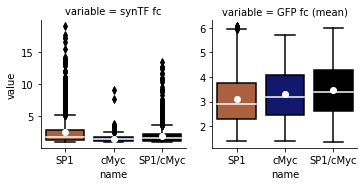

- ks test for inputs, (one-sided)
not s combi greater than SP1? not significantly different p= 0.999502905228019
* combi greater than Myc? significantly different p= 3.450251042717485e-36
- mann whitney u test for inputs
not s combi greater than SP1? not significantly different p= 1.0
* combi greater than Myc? significantly different p= 1.025425751291081e-32
- ks test for outputs, (one-sided)
* combi greater than SP1? significantly different p= 8.687224852777043e-39
* combi greater than Myc? significantly different p= 3.9403431169555865e-06
- mw test for outputs
* combi greater than SP1? significantly different p= 1.6223807064834388e-38
* combi greater than Myc? significantly different p= 1.6539953131477373e-07
!!! inputs are statistically significant by at least one test in one comparison
!!! outputs are statistically significant by all tests in all comparisons


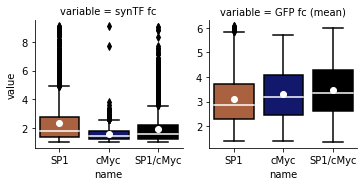

- ks test for inputs, (one-sided)
not s combi greater than SP1? not significantly different p= 0.9994290840970117
* combi greater than Myc? significantly different p= 1.0759528761971274e-34
- mann whitney u test for inputs
not s combi greater than SP1? not significantly different p= 1.0
* combi greater than Myc? significantly different p= 3.187115590124449e-31
- ks test for outputs, (one-sided)
* combi greater than SP1? significantly different p= 3.249124241006374e-40
* combi greater than Myc? significantly different p= 6.054096610980085e-06
- mw test for outputs
* combi greater than SP1? significantly different p= 8.819219797273981e-41
* combi greater than Myc? significantly different p= 2.7855449427287814e-07
!!! inputs are statistically significant by at least one test in one comparison
!!! outputs are statistically significant by all tests in all comparisons


In [26]:
inputcol="synTF fc"
for i in range(2):
    subdf=alldata

    if i==1: #only data up to max signal in myc
        maxMyc=subdf[subdf["name"]=="cMyc"][inputcol].max()
        subdf=subdf[subdf[inputcol]<=maxMyc] #cells with up to the input observed in the myc condition
    melted=pd.melt(subdf,id_vars=["name"],value_vars=[inputcol, "GFP fc (mean)"])
    #print(melted.head())

    sns.catplot(orient="v",data=melted,col="variable",y="value",x="name",
                order=["SP1", "cMyc","SP1/cMyc"], palette=colors_lines,
                kind="box",height=2.5, aspect=1., showmeans=True,
                meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"white"},
               medianprops=dict(color="w", alpha=1),sharey=False)
    #sns.boxenplot(data=alldfs,x="bin", y="GFP", hue="name",
    #            hue_order=["cMyc", "SP1", "combi"],color="white", width=0.05)
    plt.show()
    returnvals=check_significance(subdf,returnval=True)
    if returnvals[0]==1:
        print("!!! inputs are statistically significant by at least one test in one comparison")
    if returnvals[1]==1:
        print("!!! outputs are statistically significant by all tests in all comparisons")


Note that the input is still higher for SP1/cMyc as compared to Myc even if we are only taken the cells that share the same range, determined by the Myc which has the lowest maximum. Reduce a little bit the extreme cutoff so that the significance of the difference is lost:

In [27]:
inputcol="synTF"

#I have tried different cutoffs systematically, showing here the point at which it switches
for q in [0.92,0.91]:
    subdf=alldata
    q_myc=np.quantile(subdf[subdf["name"]=="cMyc"][inputcol],q)
    subdf=subdf[subdf[inputcol]<=q_myc]
    print(q,q_myc)
    returnvals=check_significance(subdf,sth=0.005,returnval=True)
    if returnvals[0]==1:
        print("!!! inputs are statistically significant by at least one test in one comparison")
    if returnvals[1]==1:
        print("!!! outputs are statistically significant by all tests in all comparisons")

    print("------")




0.92 185.6216978329418
- ks test for inputs, (one-sided)
not s combi greater than SP1? not significantly different p= 0.9595934426445561
* combi greater than Myc? significantly different p= 0.004101299956526529
- mann whitney u test for inputs
not s combi greater than SP1? not significantly different p= 0.9999958589851711
not s combi greater than Myc? not significantly different p= 0.014412151365202307
- ks test for outputs, (one-sided)
* combi greater than SP1? significantly different p= 1.764151234897575e-49
* combi greater than Myc? significantly different p= 1.01913663473867e-07
- mw test for outputs
* combi greater than SP1? significantly different p= 1.3397217093658786e-54
* combi greater than Myc? significantly different p= 2.4166606269849087e-10
!!! inputs are statistically significant by at least one test in one comparison
!!! outputs are statistically significant by all tests in all comparisons
------
0.91 181.6704786223177
- ks test for inputs, (one-sided)
not s combi greate

Pick 0.91, at which point the p-values for both one-sided tests for the inputs are >0.005. 

In [28]:
#plot of distributions of input with q_myc highlighted
q_threshold_myc=0.91 
subdf=alldata
inputcol="synTF"
q_myc=np.quantile(subdf[subdf["name"]=="cMyc"][inputcol],q_threshold_myc)

In [37]:
import matplotlib as mpl
mpl.rcParams["font.size"]=12

xticks [  0 100 200 300 400]
['0', '100', '200', '300', '> 400']
0.0285038538277149 474.717983283103 [400 498]
control 24594
[400 498]
6.52953390078619 753.621850900352 [400 791]
cMyc 6174
[400 791]
7.52034797798842 1570.89425624162 [ 400 1649]
SP1 5317
[ 400 1649]
6.5637904019095 1117.04161155224 [ 400 1172]
SP1/cMyc 5626
[ 400 1172]


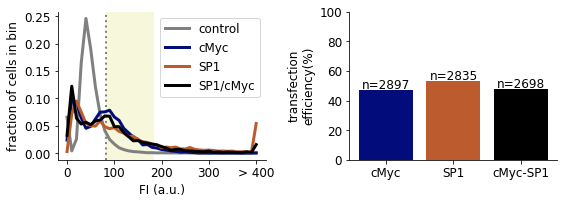

In [44]:
column="synTF"


fig,axes=plt.subplots(1,2,figsize=(8,3))
for ax in axes:
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
ax=axes[0]
ax1=axes[1]
ax.axvline(x=cutoff_val_ctrl,linestyle=":",color="gray",linewidth=2)
#ax.axvline(x=q_myc,linestyle=":",color="gray",linewdth=1)
ax.axvspan(cutoff_val_ctrl,q_myc,color="#f7f8db")

maxbin=400
step=10
bins=np.arange(0,maxbin+step+1,step)
xticks=bins[::10].copy()
print("xticks",xticks)
labels=["%d"%x for x in xticks]
labels[-1]='> '+labels[-1]
print(labels)


for d,df in enumerate(dfs_noout):
    condition=df.name
    color=colors_lines[condition]
    data=df["synTF"].values
    bins_=bins.copy()
    bins_[-1]=data.max()*1.05 #collect everything else in here
    print(data.min(),data.max(), bins_[-2:])
    print(condition,len(df))

    #hist,edges=np.histogram(data,density=True,bins=bins)
    hist,edges=np.histogram(data,bins=bins_)
    ax.plot(edges[:-1],hist/np.sum(hist),label=condition,color=color,linewidth=3)
    print(edges[-2:])
        
    if d>0:
        npos=np.sum(data>cutoff_val_ctrl)
        percentage=100*npos/len(data)
        ax1.bar(d,percentage,color=color)
        ax1.text(d-0.35,percentage+1,"n=%d"%(npos))

    
ax=axes[0]
ax.set_xticks(xticks)
ax.set_xticklabels(labels)
ax.legend()
ax.set_xlabel("FI (a.u.)")
ax.set_ylabel("fraction of cells in bin") #"density")
ax1.set_ylim(0,100)
ax1.set_ylabel("transfection\nefficiency(%)")
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(["cMyc", "SP1", "cMyc-SP1"])
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
plt.tight_layout()
plt.savefig("../../../work2/papersyn/figs/panels/IF_input_distribution_final.pdf")
plt.show()

Plot results:

In [45]:
def decorate_axis_syn(ax,fontsize=12):
    green="#c6cdad"
    blue="#d3dbe4"
    red="#e3cbc8"
    ax.fill_between([0,1],2,color=green,zorder=1)
    ax.fill_between([-1,0],2,color=blue,zorder=1)
    ax.fill_between([-1,0],-1,color=red,zorder=1)
    ax.set_xlabel(r'$S_{A,B}$',fontsize=fontsize)
    ax.set_ylabel(r'$S_{B,A}$',fontsize=fontsize)
    ax.tick_params(axis='both',labelsize=fontsize)

    #ax.legend(loc=lc,bbox_to_anchor=bbox,ncol=2)
    ax.axhline(y=0,linestyle='--',color='grey')
    ax.axvline(x=0,linestyle='--',color='grey')
    ax.set_xlim(-0.1,0.3)
    ax.set_ylim(-0.1,0.75)
    return ax

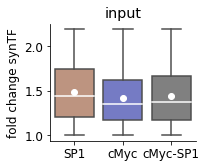

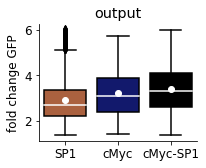

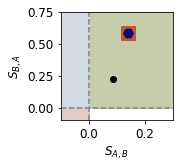

- ks test for inputs, (one-sided)
not s combi greater than SP1? not significantly different p= 0.9479535230505635
not s combi greater than Myc? not significantly different p= 0.009815523517602225
- mann whitney u test for inputs
not s combi greater than SP1? not significantly different p= 0.9999924835911838
not s combi greater than Myc? not significantly different p= 0.026885040140939693
- ks test for outputs, (one-sided)
* combi greater than SP1? significantly different p= 2.410595191849364e-49
* combi greater than Myc? significantly different p= 5.625779479329524e-08
- mw test for outputs
* combi greater than SP1? significantly different p= 2.1085966154841683e-54
* combi greater than Myc? significantly different p= 1.2776672680256465e-10


In [50]:
inputcol="synTF fc"
subdf=alldata[alldata["synTF"]<=q_myc] #cells with up to the input cutoff

#boxplot for input
melted=pd.melt(subdf,id_vars=["name"],value_vars=[inputcol])

obj=sns.catplot(orient="v",data=melted,col="variable",y="value",x="name",
            order=["SP1", "cMyc","SP1/cMyc"], palette=colors_lines_alpha,
            kind="box",height=2.5, aspect=1.2, showmeans=True,
            meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"white"},
           medianprops=dict(color="w", alpha=1),sharey=False)

ax0=obj.axes[0][0]
ax0.set_xlabel("")
ax0.set_ylabel("fold change synTF")
ax0.set_xticklabels(["SP1", "cMyc", "cMyc-SP1"])
ax0.set_title("input")
plt.tight_layout()
plt.savefig("../../../work2/papersyn/figs/panels/IF_input_final.pdf")


#boxplot for output
melted=pd.melt(subdf,id_vars=["name"],value_vars=["GFP fc (mean)"])

obj=sns.catplot(orient="v",data=melted,col="variable",y="value",x="name",
            order=["SP1", "cMyc","SP1/cMyc"], palette=colors_lines,
            kind="box",height=2.5, aspect=1.2, showmeans=True,
            meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"white"},
           medianprops=dict(color="w", alpha=1),sharey=False)

ax1=obj.axes[0][0]
ax1.set_xlabel("")
ax1.set_ylabel("fold change GFP")
ax1.set_xticklabels(["SP1", "cMyc", "cMyc-SP1"])
ax1.set_title("output")
plt.tight_layout()
plt.savefig("../../../work2/papersyn/figs/panels/IF_output_final.pdf")
plt.show()

#synergy space
#values from figure3
flow_SAB=np.mean([0.04439412, 0.14249287, 0.23346239])
flow_SBA=np.mean([0.42584902, 0.65490106 ,0.65874701])

fig,ax=plt.subplots(1,1,figsize=(2,2))
ax=decorate_axis_syn(ax)
ax.scatter(flow_SAB,flow_SBA,marker="s",color="#bc5b2d",s=200)
ax.scatter(flow_SAB,flow_SBA,marker="H",color="#030c7b",s=100)


means=subdf.groupby(["name"])["GFP fc (mean)"].mean()
mcombi=means["SP1/cMyc"]
mA=means["cMyc"]
mB=means["SP1"]
if mA<mB:
    print("different ordering")
SAB=np.log2(mcombi/mA)
SBA=np.log2(mcombi/mB)
ax.scatter(SAB,SBA,color="k")
#plt.tight_layout()
plt.savefig("../../../work2/papersyn/figs/panels/IF_syn_final.pdf",bbox_inches="tight")
plt.show()

check_significance(subdf,sth=0.005)

